<a id = Section1></a>
# **1. Introduction**

The Home Mortgage Disclosure Act (HMDA) requires many **financial institutions** to **maintain, report, and publicly disclose loan-level information** about **mortgages**. These **data help** show whether **lenders** are **serving** the **housing needs** of their communities; they **give** public officials **information** that **helps** them **make decisions and policies**; and they shed light on lending patterns that could be discriminatory. The **public data** are **modified** to **protect** applicant and borrower **privacy**.

<center><img src="https://upload.wikimedia.org/wikipedia/commons/5/5c/Great_Seal_of_the_United_States_%28obverse%29.svg" width = "40%"></center>

**<center>HMDA was originally enacted by Congress in 1975 and is implemented by Regulation C.</center>**

In general, the **primary purposes** of the Home Mortgage Disclosure Act and Regulation C are to **monitor the geographic targets of mortgage lenders**, **provide** an **identification mechanism** for any predatory **lending practices**, and to **provide** reporting **statistics** on the mortgage market **to** the **government**.

The HMDA requires certain financial institutions to collect and report data on mortgage loan applications, originations, purchases, and other related activities. The data collected through LAR includes information about the loan applicant, the property, and the loan itself.

Please find the original dataset here:

Note: Instead of using the large CSV file, I will be utilizing the sampled data available in the "Sampled_loan_data" section for the following analysis. This will allow for faster processing and better resource utilization.

https://ffiec.cfpb.gov/data-publication/snapshot-national-loan-level-dataset/2022

Please find the schema/codebook here:

https://ffiec.cfpb.gov/documentation/publications/loan-level-datasets/lar-data-fields

Note that since dataset was too large, I randomly selected **30000** rows from the original csv file & saved it as a new **Sampled_loan_data.csv** file.

<a id = Section2></a>
# **2. Problem Statement**

The problem here is to **analyze and predict** the **mortgage decisions** based on the **information provided to the machine**, **empowering** the **government** to take **rational decisions** about providing the **lending information** of the **borrower**.
<center><img src = "https://ocdn.eu/images/pulscms/NWQ7MDA_/cfe27a08-f80b-480f-b5bd-7914252c912b.jpeg"></center>

<br>

The **target feature** in the acquired data set is **action_taken** on the application of the applicant.<br>

|Target Feature|Potential Values|
| :-- | :-- |
|**action_taken**|1. Loan originated|
||2. Application approved but not accepted| 
||3. Application denied|
||4. Application withdrawn by applicant|
||5. File closed for incompleteness|
||6. Purchased loan|
||7. Preapproval request denied|
||8. Preapproval request approved but not accepted|


<a id = Section3></a>
# **3. Importing Libraries**

### **Importing Libraries**

In [1]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import random
import seaborn as sns
from scipy.stats.mstats import winsorize
from sklearn.impute import SimpleImputer
from scipy import stats
from random import randint


#evaluation metrics and preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.cluster import KMeans, AgglomerativeClustering,AffinityPropagation
from sklearn.metrics import adjusted_mutual_info_score, adjusted_rand_score, silhouette_score
from sklearn import cluster, covariance, manifold

### **PLEASE DO NOT EXECUTE BELOW CODE**


Please note that the code below utilizes a zipfile downloaded from the website (https://ffiec.cfpb.gov/data-publication/snapshot-national-loan-level-dataset/2022) for the year 2022. It randomly selects 30,000 rows from the dataset since the file is too large to be loaded in Google Colab.

**Note: Each time the code is executed, it will generate a different random sample.**

For instructors' convenience, they can download the sampled dataset from https://github.com/YanHuang1994/House-loan-prediction

In the Sampled_data section, the code will work with the pre-saved CSV file to continue the analysis.

This approach ensures that instructors can run the code without having to download the large zipfile and obtain consistent results with the pre-saved CSV file.


<a id = Section4></a>
# **4. Data Information**
From the sample, it can be seen that we have 30000 rows of data and 99 features.

This **dataset covers** all **mortgage decisions** made in **2022** . Data for additional states and years can be accessed <a href = "https://ffiec.cfpb.gov/data-publication/snapshot-national-loan-level-dataset/2022">here</a>. This dataset was **compiled by the Consumer Finance Protection Board** (CFPB) and we performed a little amount of modification.

| Records | Features | Dataset Size |
| :-- | :-- | :-- |
| 1million  |  99 | 5.6 GB|

| Id | Features | Description |
| :--| :--| :--|
|1|**action_taken**|Action taken on file. Contains: [Loan originated, Application approved but not accepted, Application denied by financial institution,|
||| Application withdrawn by applicant, File closed for incompleteness, Loan purchased by the institution

In [2]:
## instructor doesnot need to run this code and can move to sampled data section instead

#import zipfile

#zip_path = './2022_public_lar_csv.zip'

#with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#    zip_ref.extractall()

In [3]:
# Load the 30k rows to sample from the original CSV file
#file_path = './2022_public_lar_csv.csv'
#total_rows = sum(1 for _ in open(file_path)) - 1  # Get the total number of rows excluding the header

#nrows = 30000
#skiprows = sorted(random.sample(range(1, total_rows + 1), total_rows - nrows))  # Randomly select rows to skip

#df = pd.read_csv(file_path, skiprows=skiprows)

#df.head(5)

In [4]:
# Save the sampled data as a new CSV file so that each time you load random 30k rows, you do not end up with a new dataset
#sampled_file_path = './Sampled_loan_data.csv'  # i saved the sampled data here
#sample_loan_lar=df.to_csv(sampled_file_path, index=False)

#print("Sampled data saved successfully.")

In [5]:
file_path_1='./Sampled_loan_data.csv'
sampled_data=pd.read_csv(file_path_1)
sampled_data.head(10)

,activity_year,lei,derived_msa_md,state_code,county_code,census_tract,conforming_loan_limit,derived_loan_product_type,derived_dwelling_category,derived_ethnicity,...,denial_reason_2,denial_reason_3,denial_reason_4,tract_population,tract_minority_population_percent,ffiec_msa_md_median_family_income,tract_to_msa_income_percentage,tract_owner_occupied_units,tract_one_to_four_family_homes,tract_median_age_of_housing_units
0,2022,RVDPPPGHCGZ40J4VQ731,40140,CA,6065.0,6.065043e+09,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,2855,52.19,87400,60.0,688,1398,51
1,2022,RVDPPPGHCGZ40J4VQ731,43420,AZ,4003.0,4.003002e+09,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Joint,...,NaN,NaN,NaN,5280,46.27,64500,125.0,1129,1660,40
2,2022,RVDPPPGHCGZ40J4VQ731,38060,AZ,4013.0,4.013117e+09,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Hispanic or Latino,...,NaN,NaN,NaN,5194,74.70,88800,95.0,1353,1686,18
3,2022,RVDPPPGHCGZ40J4VQ731,48864,DE,10003.0,1.000301e+10,C,VA:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,4637,49.43,103900,89.0,1301,1851,68
4,2022,RVDPPPGHCGZ40J4VQ731,99999,PA,42105.0,4.210595e+10,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,2240,2.90,72900,80.0,673,1128,56
5,2022,RVDPPPGHCGZ40J4VQ731,99999,TX,48031.0,4.803195e+10,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,3631,25.23,68800,107.0,1065,1632,23
6,2022,RVDPPPGHCGZ40J4VQ731,12420,TX,48453.0,4.845300e+10,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Hispanic or Latino,...,NaN,NaN,NaN,4182,88.16,110300,61.0,482,674,17
7,2022,RVDPPPGHCGZ40J4VQ731,21340,TX,48141.0,4.814100e+10,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Hispanic or Latino,...,NaN,NaN,NaN,5785,97.75,59400,76.0,1092,1793,35
8,2022,RVDPPPGHCGZ40J4VQ731,19124,TX,48121.0,4.812102e+10,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,4424,59.67,97400,112.0,1204,1534,35
9,2022,RVDPPPGHCGZ40J4VQ731,21780,KY,21101.0,2.110102e+10,C,FHA:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,3298,9.88,83700,73.0,625,1135,44


In [6]:
sampled_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 99 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   activity_year                             30000 non-null  int64  
 1   lei                                       30000 non-null  object 
 2   derived_msa_md                            30000 non-null  int64  
 3   state_code                                29681 non-null  object 
 4   county_code                               29454 non-null  float64
 5   census_tract                              29374 non-null  float64
 6   conforming_loan_limit                     29877 non-null  object 
 7   derived_loan_product_type                 30000 non-null  object 
 8   derived_dwelling_category                 30000 non-null  object 
 9   derived_ethnicity                         30000 non-null  object 
 10  derived_race                      

<a id = Section5></a>
# **5. Data Exploration**
In Predicting Loan Eligibility, my target variable will be ` ACTION TAKEN `, which, as the name suggests is the action taken on the covered loan or application. There are 8 categories listed for this variable:

1 - Loan originated

2 - Application approved but not accepted

3 - Application denied

4 - Application withdrawn by applicant

5 - File closed for incompleteness

6 - Purchased loan

7 - Preapproval request denied

8 - Preapproval request approved but not accepted

------------------------------------------------------------
--------------------------------------------------------------

I will explore each class, but later I might combine different categories to make the variable binary.

 * **Approved** (loan originated, purchased loan, Application approved but not accepted) or
 * **Denied** (Application denied, File closed for incompleteness, Preapproval request denied)

 `For this study purposes, excluded are withdrawn applications and preapprovals approved but not accepted. The analysis focuses on clear loan approval or denial outcomes.`

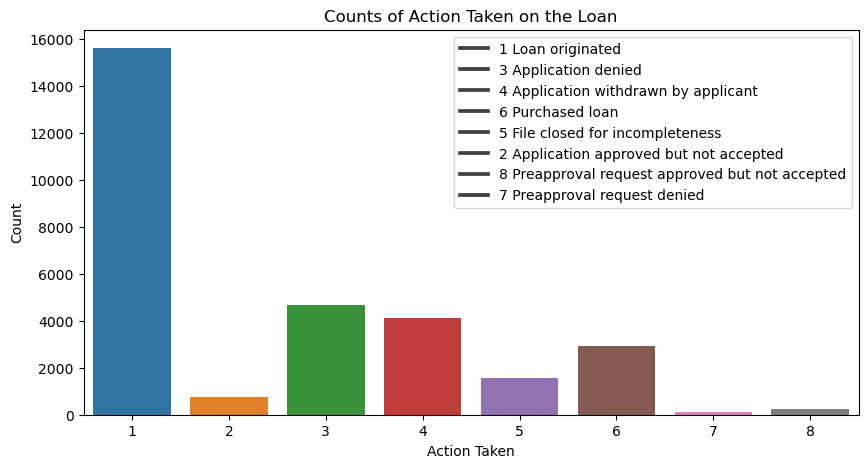

In [7]:
#check value counts for action taken variable

action_taken_counts=sampled_data['action_taken'].value_counts(dropna=False)

plt.figure(figsize=(10,5))

sns.barplot(x=action_taken_counts.index, y=action_taken_counts.values)
# Set the plot labels and title
plt.xlabel('Action Taken')
plt.ylabel('Count')
plt.title('Counts of Action Taken on the Loan')

# Define the action labels for the legend
action_labels = {
    1: 'Loan originated',
    2: 'Application approved but not accepted',
    3: 'Application denied',
    4: 'Application withdrawn by applicant',
    5: 'File closed for incompleteness',
    6: 'Purchased loan',
    7: 'Preapproval request denied',
    8: 'Preapproval request approved but not accepted'
}

# Create the legend
legend_labels = [f'{action} {action_labels[action]}' for action in action_taken_counts.index]
plt.legend(legend_labels, loc='upper right')

# Show the plot
plt.show()


We see that the most loans had been issued (originated and purchased) and the rest were either denied, withdrawn, incomplete.

<a id = Section6></a>
# **6. Data Pre-Processing**


### **6.1 Drop Features with >50% misisng values**

In [8]:
# Select variables with null values
null_variables = sampled_data.columns[sampled_data.isnull().any()]

# Display the variables with null values
print(null_variables)
print(len(null_variables))

Index(['state_code', 'county_code', 'census_tract', 'conforming_loan_limit',
       'combined_loan_to_value_ratio', 'interest_rate', 'rate_spread',
       'total_loan_costs', 'total_points_and_fees', 'origination_charges',
       'discount_points', 'lender_credits', 'loan_term',
       'prepayment_penalty_term', 'intro_rate_period', 'property_value',
       'multifamily_affordable_units', 'income', 'debt_to_income_ratio',
       'applicant_ethnicity_1', 'applicant_ethnicity_2',
       'applicant_ethnicity_3', 'applicant_ethnicity_4',
       'applicant_ethnicity_5', 'co_applicant_ethnicity_1',
       'co_applicant_ethnicity_2', 'co_applicant_ethnicity_3',
       'co_applicant_ethnicity_4', 'co_applicant_ethnicity_5',
       'applicant_race_1', 'applicant_race_2', 'applicant_race_3',
       'applicant_race_4', 'applicant_race_5', 'co_applicant_race_2',
       'co_applicant_race_3', 'co_applicant_race_4', 'co_applicant_race_5',
       'applicant_age_above_62', 'co_applicant_age_above_62',

In [9]:
#check what variables are missing what fraction of data
missing_fractions = sampled_data.isnull().mean().sort_values(ascending=False)

missing_fractions.head(50)

applicant_ethnicity_4                1.000000
co_applicant_ethnicity_5             1.000000
co_applicant_ethnicity_4             1.000000
applicant_ethnicity_5                1.000000
applicant_race_5                     0.999833
co_applicant_race_5                  0.999800
co_applicant_race_4                  0.999733
applicant_race_4                     0.999533
co_applicant_ethnicity_3             0.999533
denial_reason_4                      0.999500
applicant_ethnicity_3                0.999200
co_applicant_race_3                  0.998433
applicant_race_3                     0.996033
aus_5                                0.995767
aus_4                                0.995100
denial_reason_3                      0.994767
aus_3                                0.985333
co_applicant_race_2                  0.981767
co_applicant_ethnicity_2             0.980300
multifamily_affordable_units         0.977167
total_points_and_fees                0.974000
denial_reason_2                   

In [10]:
drop_list=sorted(list(missing_fractions[missing_fractions>0.5].index))
print(drop_list)
print(len(drop_list))

['applicant_ethnicity_2', 'applicant_ethnicity_3', 'applicant_ethnicity_4', 'applicant_ethnicity_5', 'applicant_race_2', 'applicant_race_3', 'applicant_race_4', 'applicant_race_5', 'aus_2', 'aus_3', 'aus_4', 'aus_5', 'co_applicant_age_above_62', 'co_applicant_ethnicity_2', 'co_applicant_ethnicity_3', 'co_applicant_ethnicity_4', 'co_applicant_ethnicity_5', 'co_applicant_race_2', 'co_applicant_race_3', 'co_applicant_race_4', 'co_applicant_race_5', 'denial_reason_2', 'denial_reason_3', 'denial_reason_4', 'discount_points', 'intro_rate_period', 'lender_credits', 'multifamily_affordable_units', 'origination_charges', 'prepayment_penalty_term', 'total_loan_costs', 'total_points_and_fees']
32


In [11]:
#drop variables in sampled data that are missing more than 50% of observations

sampled_data.drop(labels=drop_list, axis=1, inplace=True)
sampled_data.shape

(30000, 67)

In [12]:
#after dropping variables with more than 50% missing data we are left with 67 columns below
print(sorted(sampled_data.columns))

['action_taken', 'activity_year', 'applicant_age', 'applicant_age_above_62', 'applicant_credit_score_type', 'applicant_ethnicity_1', 'applicant_ethnicity_observed', 'applicant_race_1', 'applicant_race_observed', 'applicant_sex', 'applicant_sex_observed', 'aus_1', 'balloon_payment', 'business_or_commercial_purpose', 'census_tract', 'co_applicant_age', 'co_applicant_credit_score_type', 'co_applicant_ethnicity_1', 'co_applicant_ethnicity_observed', 'co_applicant_race_1', 'co_applicant_race_observed', 'co_applicant_sex', 'co_applicant_sex_observed', 'combined_loan_to_value_ratio', 'conforming_loan_limit', 'construction_method', 'county_code', 'debt_to_income_ratio', 'denial_reason_1', 'derived_dwelling_category', 'derived_ethnicity', 'derived_loan_product_type', 'derived_msa_md', 'derived_race', 'derived_sex', 'ffiec_msa_md_median_family_income', 'hoepa_status', 'income', 'initially_payable_to_institution', 'interest_only_payment', 'interest_rate', 'lei', 'lien_status', 'loan_amount', 'loa

### **6.2 Drop Variables Based on the Intuitiveness**

Based on the method the data was collected, some of the variables reported are duplications (examples are: observed sex and sex of the applicant, applicant_ethnicity_observed & applicant_ethnicity_1 so they are mostly correlated variables and I will remove them from my dataset).

Going over the codebook again, I will select below features that are intuitive based on subjective judgement.

Taking some time to explore Public HDMA- LAR Data Fields linked here https://ffiec.cfpb.gov/documentation/publications/loan-level-datasets/lar-data-fields, I decided to select below variables for my case study.


- `Loan Amount`: The amount of the covered loan, or the amount applied for
- `Loan Term`: The number of months after which the legal obligation will mature or terminate, or would have matured or terminated.
- `State Code` : Two-letter state code.
- `Income`: The gross annual income, in thousands of dollars, relied on in making the credit decision, or if a credit decision was not made, the gross annual income relied on in processing the application
- `Debt-to-Income Ratio`: The ratio, as a percentage, of the applicant’s or borrower’s total monthly debt to the total monthly income relied on in making the credit decision.< 20%; 20%-<30%; 30%-<36%; 37%, 38%, 39%, 40%, 41%, 42%, 43%, 44%, 45%, 46%, 47%, 48%, 49%, 50%-60%, 60%; NA; Exempt.

- `Action Taken`: The action taken on the covered loan or application -1 - Loan originated; 2 - Application approved but not accepted; 3 - Application denied; 4 - Application withdrawn by applicant; 5 - File closed for incompleteness; 6 - Purchased loan; 7 - Preapproval request denied; 8 - Preapproval request approved but not accepted

- `Purpose of Loan`:  The purpose of covered loan or application; 1 - Home purchase; 2 - Home improvement; 31 - Refinancing; 32 - Cash-out refinancing; 4 - Other purpose; 5 - Not applicable.

- `Combined Loan-to-Value Ratio`: The ratio of the total amount of debt secured by the property to the value of the property relied on in making the credit decision

- `Age`: The age, in years, of the applicant or borrower.< 25;
25-34; 35-44; 45-54; 55-64; 65-74, > 74, 8888.
-
`Applicant_credit_score_type`: 1 - Equifax Beacon 5.0
2 - Experian Fair Isaac
3 - FICO Risk Score Classic 04
4 - FICO Risk Score Classic 98
5 - VantageScore 2.0
6 - VantageScore 3.0
7 - More than one credit scoring model
8 - Other credit scoring model
9 - Not applicable
1111 - Exempt

- `Business or commercial purpose`: Whether the covered loan or application is primarily for a business or commercial purpose: 1 - Primarily for a business or commercial purpose; 2 - Not primarily for a business or commercial purpose; 1111 - Exempt
- `Property value`: The value of the property securing the covered loan or, in the case of an application, proposed to secure the covered loan, relied on in making the credit decision.
- `Occupancy Type`: Occupancy type for the dwelling: 1 - Principal residence; 2 - Second residence; 3 - Investment property
- `Interest Rate`: The interest rate for the covered loan or application.
                                   
-  `Purchaser_type`:  Type of entity purchasing a covered loan from the institution, 0 - Not applicable; 1 - Fannie Mae; 2 - Ginnie Mae; 3 - Freddie Mac; 4 - Farmer Mac; 5 - Private securitizer; 6 - Commercial bank, savings bank, or savings association; 71 - Credit union, mortgage company, or finance company; 72 - Life insurance company; 8 - Affiliate institution; 9 - Other type of purchaser
-  `Preapproval`: Whether the covered loan or application involved a request for a preapproval of a home purchase loan under a preapproval program - 1 Yes, 2 no
- `Loan_type`: The type of covered loan or application, 1 - Conventional (not insured or guaranteed by FHA, VA, RHS, or FSA); 2 - Federal Housing Administration insured (FHA); 3 - Veterans Affairs guaranteed (VA); 4 - USDA Rural Housing Service or Farm Service Agency guaranteed (RHS or FSA)                        
- `Lien_status`- Lien status of the property securing the covered loan, or in the case of an application, proposed to secure the covered loan- 1 - Secured by a first lien; 2 - Secured by a subordinate lien                     
-  `Hoepa_status`: Whether the covered loan is a high-cost mortgage - 1 - High-cost mortgage; 2 - Not a high-cost mortgage; 3 - Not applicable
-  `Negative_amortization`: Whether the contractual terms include, or would have included, a term that would cause the covered loan to be a negative amortization loan; 1 - Negative amortization; 2 - No negative amortization; 1111 - Exempt             
- `Balloon_payment`: Whether the contractual terms include, or would have included, a balloon payment - 1 - Balloon payment; 2 - No balloon payment; 1111 - Exempt
-  `Co_applicant_credit_score_type`: The name and version of the credit scoring model used to generate the credit score, or scores, relied on in making the credit decision -1 - Equifax Beacon 5.0; 2 - Experian Fair Isaac; 3 - FICO Risk Score Classic 04; 4 - FICO Risk Score Classic 98; 5 - VantageScore 2.0; 6 - VantageScore 3.0; 7 - More than one credit scoring model; 8 - Other credit scoring model; 9 - Not applicable; 10 - No co-applicant; 1111 - Exempt
- `Applicant_race` 1 - American Indian or Alaska Native; 2 - Asian; 21 - Asian Indian; 22 - Chinese; 23 - Filipino; 24 - Japanese; 25 - Korean; 26 - Vietnamese
27 - Other Asian; 3 - Black or African American; 4 - Native Hawaiian or Other Pacific Islander; 41 - Native Hawaiian; 42 - Guamanian or Chamorro; 43 - Samoan; 44 - Other Pacific Islander; 5 - White; 6 - Information not provided by applicant in mail, internet, or telephone application; 7 - Not applicable
- `tract_one_to_four_family_homes` - Dwellings that are built to houses with fewer than 5 families       
- `tract_owner_occupied_units` - Number of dwellings, including individual condominiums, that are lived in by the owner
- `Applicant_sex`: 1 - Male; 2 - Female; 3 - Information not provided by applicant in mail, internet, or telephone application; 4 - Not applicable
6 - Applicant selected both male and female
- `Ffiec_msa_md_median_family_income`  FFIEC Median family income in dollars for the MSA/MD in which the tract is located (adjusted annually by FFIEC)
 25

In [13]:
keep_list=['action_taken', 'applicant_age', 'applicant_race_1', 'applicant_sex', 'applicant_credit_score_type', 'balloon_payment', 'business_or_commercial_purpose',
            'co_applicant_credit_score_type', 'combined_loan_to_value_ratio', 'debt_to_income_ratio', 'ffiec_msa_md_median_family_income', 'hoepa_status', 'income',
            'loan_amount', 'loan_purpose', 'loan_term', 'interest_rate', 'loan_type','lien_status', 'state_code', 'negative_amortization', 'preapproval', 'purchaser_type', 'property_value', 'occupancy_type', 'tract_one_to_four_family_homes', 'tract_owner_occupied_units']

len(keep_list)

27

In [14]:
drop_list_selected = [col for col in sampled_data.columns if col not in keep_list]

sampled_data.drop(labels=drop_list_selected, axis=1, inplace=True)

sampled_data.shape

(30000, 27)

From the selected variables and inspecting the codebook, we see that there are **9 continuous variables** and **18 categorical variables** which are already encoded (I will need to correct the encoding for some of those variables but for now I will explore correlation between `loan action` and continuous variables using Pearson correlation coefficient & `loan action` and encoded categorical variables using Chi square & Cramer's V association.

In [15]:
# note that some of the numeric variables are labeled as object ( the reason is EXEMPT value included in variables
## based on codebook definiotions.
## I will do data cleaning for numeric and cat variables in next section.)
sampled_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 27 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   state_code                         29681 non-null  object 
 1   action_taken                       30000 non-null  int64  
 2   purchaser_type                     30000 non-null  int64  
 3   preapproval                        30000 non-null  int64  
 4   loan_type                          30000 non-null  int64  
 5   loan_purpose                       30000 non-null  int64  
 6   lien_status                        30000 non-null  int64  
 7   business_or_commercial_purpose     30000 non-null  int64  
 8   loan_amount                        30000 non-null  int64  
 9   combined_loan_to_value_ratio       20169 non-null  object 
 10  interest_rate                      19593 non-null  object 
 11  hoepa_status                       30000 non-null  int

### **6.3 Drop Features based on the correlation**

Now I will do some data wrangling for both numeric and categorical variables and will drop variables based on correlation if required.

##### **Numeric Variables**

Based on the codebook decsriptions, actual numeric variables (which are not already encoded) are:



1. `loan_term`
2. `income`
3. `combined_loan_to_value_ratio`
4. `property_value`
5. `interest_rate`
6. `ffiec_msa_md_median_family_income`
7. `loan_amount`
8. `tract_owner_occupied_units`
9. `tract_one_to_four_family_homes`


*Note: They appear as object since some rows within the columns have EXEMPT or E as a provided value.*


In [16]:
#encode Action_taken as binary moving forward for this analysis

def action(value):
  if value in [1, 2, 6]:
   return 1
  elif value in [3, 5, 7]:
   return 2
  else:
    return None

sampled_data['action_taken']=sampled_data['action_taken'].apply(action)

## as I mentioned in the beginning of  Data Exploration section,
# For this study purposes, when applicant withdraws the application or preapproval request is approved but not accepted, do not indicate approval or denial of the actual loan application
# So I will drop the observations that had those action status


# Drop rows with NaN values in the 'action_taken' column
sampled_data.dropna(subset=['action_taken'], inplace=True)

In [17]:
#freq of each outcome
sampled_data['action_taken'].value_counts()

1.0    19327
2.0     6330
Name: action_taken, dtype: int64

In [18]:
#convert to numeric below 4 variables that appeared as objects instead of num
sampled_data['loan_term']=pd.to_numeric(sampled_data['loan_term'], errors='coerce')
sampled_data['combined_loan_to_value_ratio']=pd.to_numeric(sampled_data['combined_loan_to_value_ratio'], errors='coerce')
sampled_data['property_value']=pd.to_numeric(sampled_data['property_value'], errors='coerce')
sampled_data['interest_rate']=pd.to_numeric(sampled_data['interest_rate'], errors='coerce')

#fill NaN values with mean values
sampled_data['loan_term'].fillna(sampled_data['loan_term'].mean(), inplace=True)
sampled_data['combined_loan_to_value_ratio'].fillna(sampled_data['combined_loan_to_value_ratio'].mean(), inplace=True)
sampled_data['property_value'].fillna(sampled_data['property_value'].mean(), inplace=True)
sampled_data['interest_rate'].fillna(sampled_data['interest_rate'].mean(), inplace=True)

#fill missing values of income with mean
sampled_data['income'].fillna(sampled_data['income'].mean(), inplace=True)

sampled_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25657 entries, 0 to 29999
Data columns (total 27 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   state_code                         25516 non-null  object 
 1   action_taken                       25657 non-null  float64
 2   purchaser_type                     25657 non-null  int64  
 3   preapproval                        25657 non-null  int64  
 4   loan_type                          25657 non-null  int64  
 5   loan_purpose                       25657 non-null  int64  
 6   lien_status                        25657 non-null  int64  
 7   business_or_commercial_purpose     25657 non-null  int64  
 8   loan_amount                        25657 non-null  int64  
 9   combined_loan_to_value_ratio       25657 non-null  float64
 10  interest_rate                      25657 non-null  float64
 11  hoepa_status                       25657 non-null  int

In [19]:
#filter action_taken( target var) &  actual numerical variables based on the codebook for pearson coefficient
numeric_df=sampled_data[['action_taken', 'loan_term', 'income', 'combined_loan_to_value_ratio', 'property_value', 'interest_rate', 'ffiec_msa_md_median_family_income', 'loan_amount', 'tract_owner_occupied_units', 'tract_one_to_four_family_homes']]


rounded_num_df = numeric_df.round(5)
print(rounded_num_df.describe())
numeric_df.info()



       action_taken     loan_term        income  combined_loan_to_value_ratio  \
count  25657.000000  25657.000000  25657.000000                  25657.000000   
mean       1.246716    322.637819    134.384010                     78.368773   
std        0.431109     79.275182    296.936871                    624.225347   
min        1.000000      1.000000   -851.000000                      0.530000   
25%        1.000000    322.637820     64.000000                     67.956000   
50%        1.000000    360.000000    105.000000                     78.368770   
75%        1.000000    360.000000    138.000000                     83.600000   
max        2.000000    676.000000  37409.000000                 100000.000000   

       property_value  interest_rate  ffiec_msa_md_median_family_income  \
count    2.565700e+04   25657.000000                       25657.000000   
mean     5.411920e+05       4.782843                       91783.380754   
std      1.857273e+06       1.331730         

I see that most of my numeric variables are suffering from extreme outliers. I will try to use *winsorization technique at 95 %ile* for variables and log transform income, since it contains negative values.

In [20]:
#winsorize : loan term, combined loan to value ratios, property value, capping at 90%

winsorized_cols=['loan_term', 'combined_loan_to_value_ratio', 'property_value', 'interest_rate', 'loan_amount', 'tract_owner_occupied_units', 'tract_one_to_four_family_homes']

for col in winsorized_cols:
  sampled_data[col]=winsorize(sampled_data[col], limits=(0, 0.05), inplace=True)

print(sampled_data[['loan_term', 'combined_loan_to_value_ratio', 'property_value', 'interest_rate', 'loan_amount', 'tract_owner_occupied_units', 'tract_one_to_four_family_homes']].describe())

#log transform income ( it has some negative values)
sampled_data['income']=np.log1p(sampled_data['income']) ## np.log1p() computes the natural logarithm of the 'income' column after adding 1 to each value. The function handles negative values by transforming them appropriately.
#nan values are returned for neg values so I ll have to fill them again with mean

sampled_data['income'].fillna(sampled_data['income'].mean(), inplace=True)

#check outcomes
print(sampled_data[['loan_term', 'combined_loan_to_value_ratio', 'property_value', 'interest_rate', 'loan_amount', 'tract_owner_occupied_units', 'tract_one_to_four_family_homes', 'income']].describe())


          loan_term  combined_loan_to_value_ratio  property_value  \
count  25657.000000                  25657.000000    2.565700e+04   
mean     320.892720                     74.125892    4.563762e+05   
std       77.054928                     18.768196    2.669610e+05   
min        1.000000                      0.530000    5.000000e+03   
25%      322.637819                     67.956000    2.550000e+05   
50%      360.000000                     78.368774    4.050000e+05   
75%      360.000000                     83.600000    5.411920e+05   
max      360.000000                     99.500000    1.155000e+06   

       interest_rate    loan_amount  tract_owner_occupied_units  \
count   25657.000000   25657.000000                25657.000000   
mean        4.722352  258809.096933                 1192.622208   
std         1.165820  184263.638403                  523.107759   
min         0.000000    5000.000000                    0.000000   
25%         4.000000  105000.000000        

D:\Anaconda3\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\Anaconda3\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [21]:
#### NOW AGAIN select numeric variables from sampled data that is cleaner.
#filter action_taken( target var) &  actual numerical variables based on the codebook for pearson coefficient
numeric_df_clean=sampled_data[['action_taken', 'loan_term', 'income', 'combined_loan_to_value_ratio', 'property_value', 'interest_rate', 'ffiec_msa_md_median_family_income', 'loan_amount', 'tract_owner_occupied_units', 'tract_one_to_four_family_homes']]


rounded_num_df_clean = numeric_df_clean.round(5)
print(rounded_num_df_clean.describe())
numeric_df_clean.info()


       action_taken     loan_term       income  combined_loan_to_value_ratio  \
count  25657.000000  25657.000000  25657.00000                  25657.000000   
mean       1.246716    320.892720         -inf                     74.125891   
std        0.431109     77.054928          NaN                     18.768196   
min        1.000000      1.000000         -inf                      0.530000   
25%        1.000000    322.637820      4.17439                     67.956000   
50%        1.000000    360.000000      4.66344                     78.368770   
75%        1.000000    360.000000      4.93447                     83.600000   
max        2.000000    360.000000     10.52969                     99.500000   

       property_value  interest_rate  ffiec_msa_md_median_family_income  \
count    2.565700e+04   25657.000000                       25657.000000   
mean     4.563762e+05       4.722351                       91783.380754   
std      2.669610e+05       1.165820                  

In [22]:
corr=numeric_df_clean.corr()

num_corr_actiontaken=abs(corr['action_taken'])

In [23]:
num_corr_actiontaken.sort_values(ascending=False).round(5)

action_taken                         1.00000
income                               0.20965
loan_amount                          0.18890
ffiec_msa_md_median_family_income    0.09233
tract_owner_occupied_units           0.07533
tract_one_to_four_family_homes       0.05732
loan_term                            0.04489
interest_rate                        0.02970
combined_loan_to_value_ratio         0.01782
property_value                       0.01621
Name: action_taken, dtype: float64

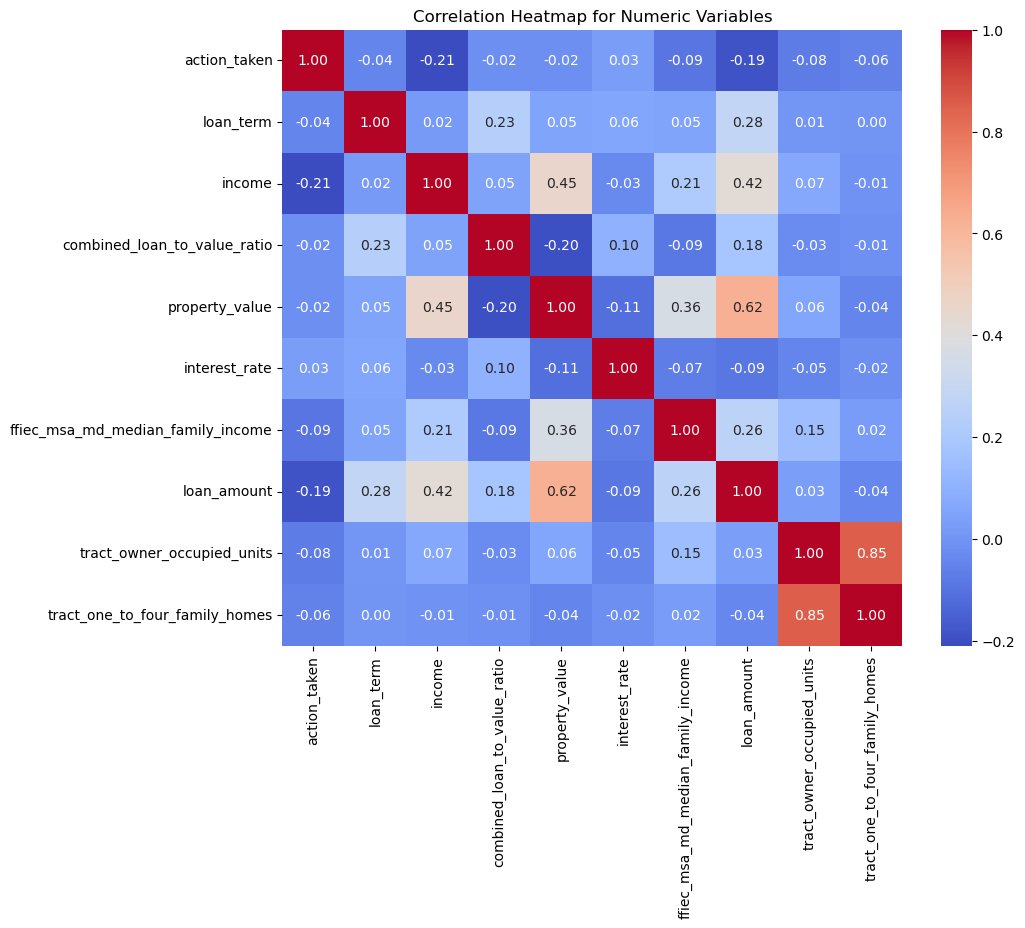

In [24]:
#visualize
plt.figure(figsize=(10, 8))
sns.heatmap(corr,  annot=True, cmap='coolwarm', fmt='.2f')


plt.title('Correlation Heatmap for Numeric Variables')
plt.show()

In [25]:
# I won't drop those variables in the end even though correlation is almost non-existant
drop_list_corr = sorted(list(num_corr_actiontaken[num_corr_actiontaken < 0.02].index))
print(drop_list_corr)

['combined_loan_to_value_ratio', 'property_value']


Surprisingly, the variables I would anticipate to have higher correlation to action taken such as combined_loan_to_value_ratio and property value are at the very bottom of the list. However I decided to keep those variables in my models to further evaluate their importance.

### **6.4 Categorical Variables Encoding**

Remaining 18 variables are encoded categorical features:

 1.   `action_taken`

 2.   `purchaser_type`                   
 3.  `preapproval`                       
 4.   `loan_type`                         
 5.   `loan_purpose`                     
 6.   `lien_status`                     
 7.   `business_or_commercial_purpose`   
 8.   `hoepa_status`                    
 9.   `negative_amortization`             
 10.  `balloon_payment`                  
 11.  `occupancy_type`                  
 12.  `debt_to_income_ratio`           
 13.  `co_applicant_credit_score_type`  
 14.  `applicant_race_1 `               
 15.  `applicant_sex `                  
 16.  `applicant_age`  
 17.  `state_code `
 18. `applicant_credit_score_type`



Based on the codebook information & descriptions, i want to explore and encode below variables more intuitively.

- **business_or_commercial_purpose**

- **negative_amortization**

- **balloon_payment**

- **co_applicant_credit_score_type**

- **applicant_age**

- **debt_to_income_ratio**  

- **state_code**    

In [26]:
# encode debt to income ratio & for ranges provide one value which is midpoint of the range
import statistics as stats

def convert(value):
  if value == '<20%':
    return 20
  elif value == '20%-<30%':
    return 25
  elif value == '30%-<36%':
    return 33
  elif value == '50%-60%':
    return 55
  elif value == '>60%':
    return 65
  elif value in ['NA', 'Exempt', 'E']:
   return None
  else:
    return value

sampled_data['debt_to_income_ratio']=sampled_data['debt_to_income_ratio'].apply(convert)


In [27]:
#check outcomes
print(sampled_data.debt_to_income_ratio.value_counts())

#fill missing values for debt to income with the mode
sampled_data['debt_to_income_ratio'].fillna(sampled_data['debt_to_income_ratio'].mode()[0], inplace=True)

sampled_data['debt_to_income_ratio']=pd.to_numeric(sampled_data['debt_to_income_ratio'])

25    3197
33    2978
55    1664
20    1438
65    1271
44     821
42     815
43     715
49     670
39     669
40     662
41     660
38     638
37     626
45     598
36     596
47     518
48     506
46     502
Name: debt_to_income_ratio, dtype: int64


In [28]:
#encode age category more intuitively, use the max value for the provided age range

def age_bins(x):
  if x == '<25':
    return 24
  elif x == '25-34':
    return 34
  elif x=='35-44':
    return 44
  elif x=='45-54':
    return 54
  elif x=='55-64':
    return 64
  elif x=='65-74':
    return 74
  elif x=='>74':
    return 75
  else:
    return None


#apply function to applicant age
sampled_data['applicant_age']=sampled_data['applicant_age'].apply(age_bins)

#fill in NAN values with mode
sampled_data['applicant_age'].fillna(sampled_data['applicant_age'].mode()[0], inplace=True)



In [29]:
#check outcomes
sampled_data['applicant_age'].value_counts()

44.0    8696
54.0    4942
34.0    4411
64.0    3886
74.0    2221
75.0     870
24.0     631
Name: applicant_age, dtype: int64

In [30]:
# fill na values with state code

sampled_data['state_code'].fillna(sampled_data['state_code'].mode()[0], inplace=True)
sampled_data['applicant_race_1'].fillna(sampled_data['applicant_race_1'].mode()[0], inplace=True)

In [31]:
#explore variables that have 1111-Exempt as their values and fill with the mode
sampled_data['business_or_commercial_purpose'].value_counts()


2       23935
1        1179
1111      543
Name: business_or_commercial_purpose, dtype: int64

In [32]:
from scipy import stats

sampled_data['business_or_commercial_purpose'].replace(to_replace=1111, value=stats.mode(sampled_data['business_or_commercial_purpose']).mode[0], inplace=True)

sampled_data['negative_amortization'].replace(to_replace=1111, value=stats.mode(sampled_data['negative_amortization']).mode[0], inplace=True)

sampled_data['balloon_payment'].replace(to_replace=1111, value=stats.mode(sampled_data['balloon_payment']).mode[0], inplace=True)

sampled_data['co_applicant_credit_score_type'].replace(to_replace=[1111, 9], value=stats.mode(sampled_data['co_applicant_credit_score_type']).mode[0], inplace=True)

sampled_data['applicant_credit_score_type'].replace(to_replace=[1111, 9], value=stats.mode(sampled_data['applicant_credit_score_type']).mode[0], inplace=True)


C:\Users\DELL\AppData\Local\Temp\ipykernel_32380\3049353041.py:3: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  sampled_data['business_or_commercial_purpose'].replace(to_replace=1111, value=stats.mode(sampled_data['business_or_commercial_purpose']).mode[0], inplace=True)
C:\Users\DELL\AppData\Local\Temp\ipykernel_32380\3049353041.py:5: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will

In [33]:
sampled_data['co_applicant_credit_score_type'].value_counts()

10    21285
1      1233
2      1097
3      1069
8       507
7       200
11      196
6        41
4        25
5         4
Name: co_applicant_credit_score_type, dtype: int64

In [34]:
#create a new variable from co applicant credit score type - whether there was a co applicant or no

def co_applicant(value):
  if value in [1, 2, 3, 4, 5, 6, 7, 8]:
    return 1
  else:
    return 0

sampled_data['has_coapplicant']=sampled_data['co_applicant_credit_score_type'].apply(co_applicant)

In [35]:
#explore now only encoded categorical variables

drop_cols=sampled_data[['loan_term', 'income', 'combined_loan_to_value_ratio', 'property_value', 'interest_rate', 'ffiec_msa_md_median_family_income', 'loan_amount', 'tract_owner_occupied_units', 'tract_one_to_four_family_homes']]
cat_df = sampled_data.drop(columns=drop_cols)
print(cat_df.info())
print(cat_df.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25657 entries, 0 to 29999
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   state_code                      25657 non-null  object 
 1   action_taken                    25657 non-null  float64
 2   purchaser_type                  25657 non-null  int64  
 3   preapproval                     25657 non-null  int64  
 4   loan_type                       25657 non-null  int64  
 5   loan_purpose                    25657 non-null  int64  
 6   lien_status                     25657 non-null  int64  
 7   business_or_commercial_purpose  25657 non-null  int64  
 8   hoepa_status                    25657 non-null  int64  
 9   negative_amortization           25657 non-null  int64  
 10  balloon_payment                 25657 non-null  int64  
 11  occupancy_type                  25657 non-null  int64  
 12  debt_to_income_ratio            

**Correlation coefficient between categorical variables using Chi-square test of independence**


 **Chi-squared statistic**
 - Chi-Square statistic meausres the discrepency between the observed frequencies and the expected frequencies in a contingency table.
 - Larger values of the chi-square statisc indicate a greater discrepency or a stronger association between the variables.


**P-value**
 - The p-value represents the probability of obtaining the observed data (or data more extreme) if the null hypothesis is true.
 - A smaller p-value suggests stronger evidence against the null hypothesis, indicating a significant association between the variables.

In [36]:
# Disable warnings
import warnings
warnings.filterwarnings("ignore")


#categorical variable assoac
from scipy.stats import chi2_contingency

# Create an empty Df to store the chi-square test results
association_results = pd.DataFrame(columns=['Variable1', 'Variable2', 'Chi2', 'P-value'])

# target var
variable1 = 'action_taken'

# Iterate through the remaining variables
for variable2 in cat_df.columns:
    if variable2 != variable1:
        # Create a contingency table
        contingency_table = pd.crosstab(cat_df[variable1], cat_df[variable2])

        # Perform the chi-square test of independence
        chi2, p_value, _, _ = chi2_contingency(contingency_table)

        # Append the results to the association_results DataFrame
        association_results = association_results.append({'Variable1': variable1, 'Variable2': variable2, 'Chi2': chi2.round(5), 'P-value': p_value.round(5)}, ignore_index=True)

# Print the association results
association_results


,Variable1,Variable2,Chi2,P-value
0,action_taken,state_code,205.28424,0.00000
1,action_taken,purchaser_type,6721.38779,0.00000
2,action_taken,preapproval,14.03400,0.00018
3,action_taken,loan_type,29.68788,0.00000
4,action_taken,loan_purpose,1578.36335,0.00000
5,action_taken,lien_status,518.69624,0.00000
6,action_taken,business_or_commercial_purpose,18.02156,0.00002
7,action_taken,hoepa_status,15021.51118,0.00000
8,action_taken,negative_amortization,0.02672,0.87016
9,action_taken,balloon_payment,8.97368,0.00274


P Values are significantly small for all the variables, except negative amortization & preapproval requested. Small P-values (< alpha=0.05) indicate a strong association between action taken and other categorical variables.

**After cleaning both Numerical and Categorical variables and exploring the correlation/association between target (action_taken) and remaining features, I decided to keep all 27 variables + action taken (target var) for my model building.**

### **6.5 Visualizations of some variables**



In [37]:
sampled_data.head(10)
sampled_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25657 entries, 0 to 29999
Data columns (total 28 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   state_code                         25657 non-null  object 
 1   action_taken                       25657 non-null  float64
 2   purchaser_type                     25657 non-null  int64  
 3   preapproval                        25657 non-null  int64  
 4   loan_type                          25657 non-null  int64  
 5   loan_purpose                       25657 non-null  int64  
 6   lien_status                        25657 non-null  int64  
 7   business_or_commercial_purpose     25657 non-null  int64  
 8   loan_amount                        25657 non-null  int64  
 9   combined_loan_to_value_ratio       25657 non-null  float64
 10  interest_rate                      25657 non-null  float64
 11  hoepa_status                       25657 non-null  int

##### **Visualize Numerical Variables**

loan_term
income
combined_loan_to_value_ratio
property_value
interest_rate
ffiec_msa_md_median_family_income
loan_amount

> **`Feature: Income`**

         income
count  25657.00
mean       1.71
std        0.18
min        0.00
25%        1.65
50%        1.73
75%        1.78
max        2.44


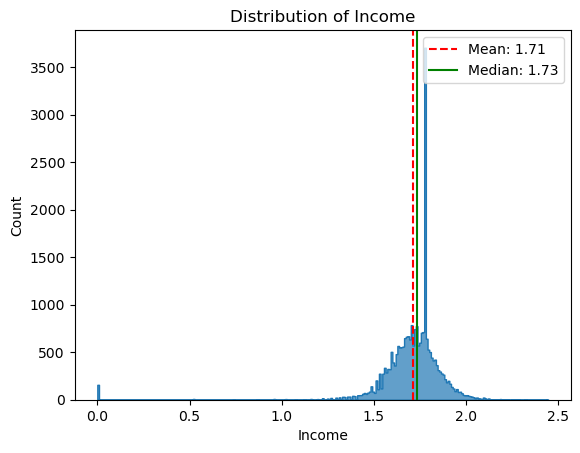

In [38]:
#winsorize : loan term, combined loan to value ratios, property value, capping at 90%

winsorized_cols=['loan_term', 'combined_loan_to_value_ratio', 'property_value', 'interest_rate', 'loan_amount', 'tract_owner_occupied_units', 'tract_one_to_four_family_homes']

for col in winsorized_cols:
  sampled_data[col]=winsorize(sampled_data[col], limits=(0, 0.05), inplace=True)

#log transform income ( it has some negative values)
sampled_data['income']=np.log1p(sampled_data['income']) ## np.log1p() computes the natural logarithm of the 'income' column after adding 1 to each value. The function handles negative values by transforming them appropriately.
#nan values are returned for neg values so I ll have to fill them again with mean

sampled_data['income'].fillna(sampled_data['income'].mean(), inplace=True)


#explore income

print(sampled_data[['income']].describe().round(2))

#visualize
sns.histplot(sampled_data['income'], alpha=0.7, element='step')

# Calculate the mean & median
mean_income = sampled_data['income'].mean()
median_income=sampled_data['income'].median()

# Add a red line at the mean value & green to median
plt.axvline(x=mean_income, color='red', linestyle='--', label=f"Mean: {mean_income:.2f}")
plt.axvline(x=median_income, color='g', label=f"Median: {median_income:.2f}")


plt.title("Distribution of Income")
plt.xlabel("Income")
plt.legend()
plt.show()

> **`Feature: property_value`**

       property_value
count         25657.0
mean         456376.0
std          266961.0
min            5000.0
25%          255000.0
50%          405000.0
75%          541192.0
max         1155000.0


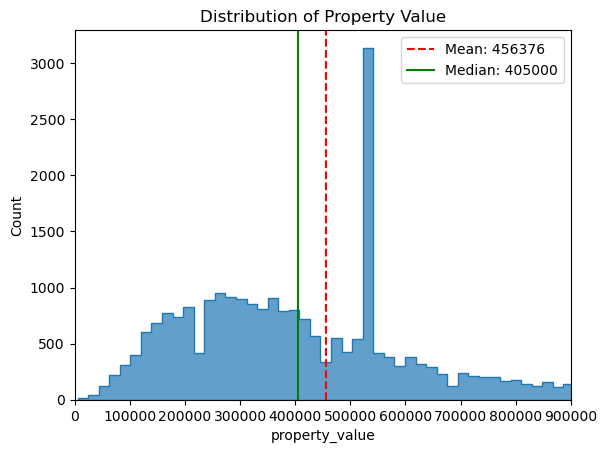

In [41]:
print(sampled_data[['property_value']].describe().round(0))


#visualize

sns.histplot(sampled_data['property_value'], alpha=0.7, element='step')
plt.xlim(0, 900000)
plt.title("Distribution of Property Value")

mean_pvalue=sampled_data['property_value'].mean()
median_pvalue=sampled_data['property_value'].median()

plt.axvline(x=mean_pvalue, color='r', linestyle='--', label=f"Mean: {mean_pvalue:.0f}")
plt.axvline(x=median_pvalue, color='g', label=f"Median: {median_pvalue:.0f}")

plt.legend()
plt.show()


> **`Feature: interest_rate`**


       interest_rate
count      25657.000
mean           4.722
std            1.166
min            0.000
25%            4.000
50%            4.783
75%            5.375
max            7.000


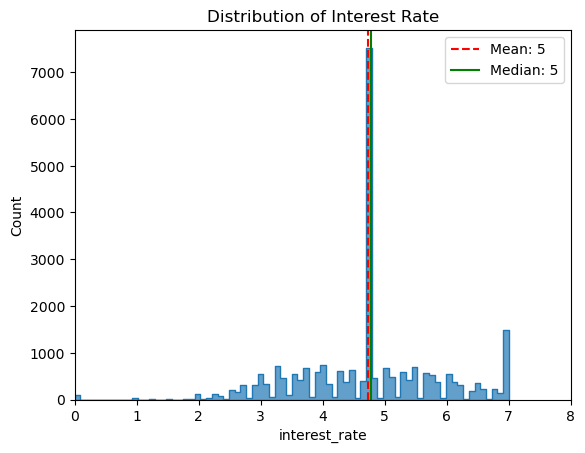

In [42]:
print(sampled_data[['interest_rate']].describe().round(3))


#visualize

sns.histplot(sampled_data['interest_rate'], alpha=0.7, element='step')
plt.xlim(0, 8)
plt.title("Distribution of Interest Rate")

mean_intvalue=sampled_data['interest_rate'].mean()
median_intvalue=sampled_data['interest_rate'].median()

plt.axvline(x=mean_intvalue, color='r', linestyle='--', label=f"Mean: {mean_intvalue:.0f}")
plt.axvline(x=median_intvalue, color='g', label=f"Median: {median_intvalue:.0f}")

plt.legend()
plt.show()


> **`Feature: ffiec_msa_md_median_family_income`**

       ffiec_msa_md_median_family_income
count                            25657.0
mean                             91783.0
std                              22269.0
min                                  0.0
25%                              80100.0
50%                              90700.0
75%                             101800.0
max                             168300.0


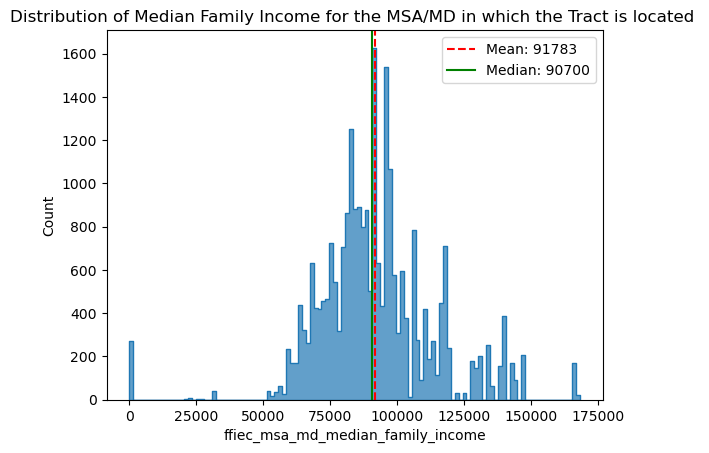

In [43]:
print(sampled_data[['ffiec_msa_md_median_family_income']].describe().round(0))


#visualize

sns.histplot(sampled_data['ffiec_msa_md_median_family_income'], alpha=0.7, element='step')
plt.title("Distribution of Median Family Income for the MSA/MD in which the Tract is located ")

mean_ffivalue=sampled_data['ffiec_msa_md_median_family_income'].mean()
median_ffivalue=sampled_data['ffiec_msa_md_median_family_income'].median()

plt.axvline(x=mean_ffivalue, color='r', linestyle='--', label=f"Mean: {mean_ffivalue:.0f}")
plt.axvline(x=median_ffivalue, color='g', label=f"Median: {median_ffivalue:.0f}")

plt.legend()
plt.show()

##### **Visualize Some Categorical Variables**

> **`Feature: Preapproval Requested`**

Number of individuals with preapproval who were accepted for a loan: 530
Percentage of individuals with preapproval who were accepted for a loan: 2.0657130607631444


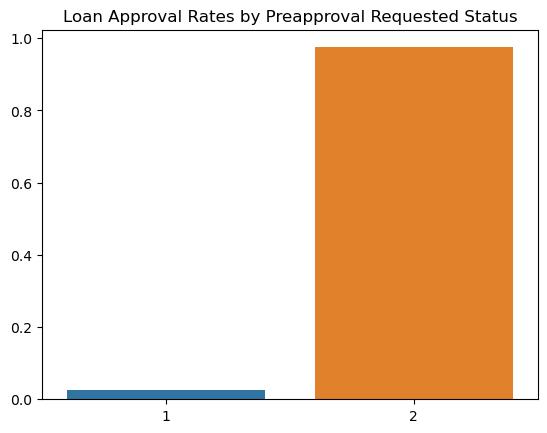

In [44]:
# Filter the DataFrame for rows with preapproval and action_taken as 'accepted'
preapproval_accepted = sampled_data[(sampled_data['preapproval'] == 1) & (sampled_data['action_taken'] == 1)]

# Calculate the count and percentage of preapproval accepted loans
preapproval_accepted_count = len(preapproval_accepted)
preapproval_accepted_percentage = preapproval_accepted_count / len(sampled_data) * 100

# Display the count and percentage
print("Number of individuals with preapproval who were accepted for a loan:", preapproval_accepted_count)
print("Percentage of individuals with preapproval who were accepted for a loan:", preapproval_accepted_percentage)

# Plot the bar graph of preapproval rates
preapproval_rates = sampled_data['preapproval'].value_counts(normalize=True)
sns.barplot(x=preapproval_rates.index, y=preapproval_rates.values)


plt.title("Loan Approval Rates by Preapproval Requested Status")
plt.show()

> **`Feature: State`**

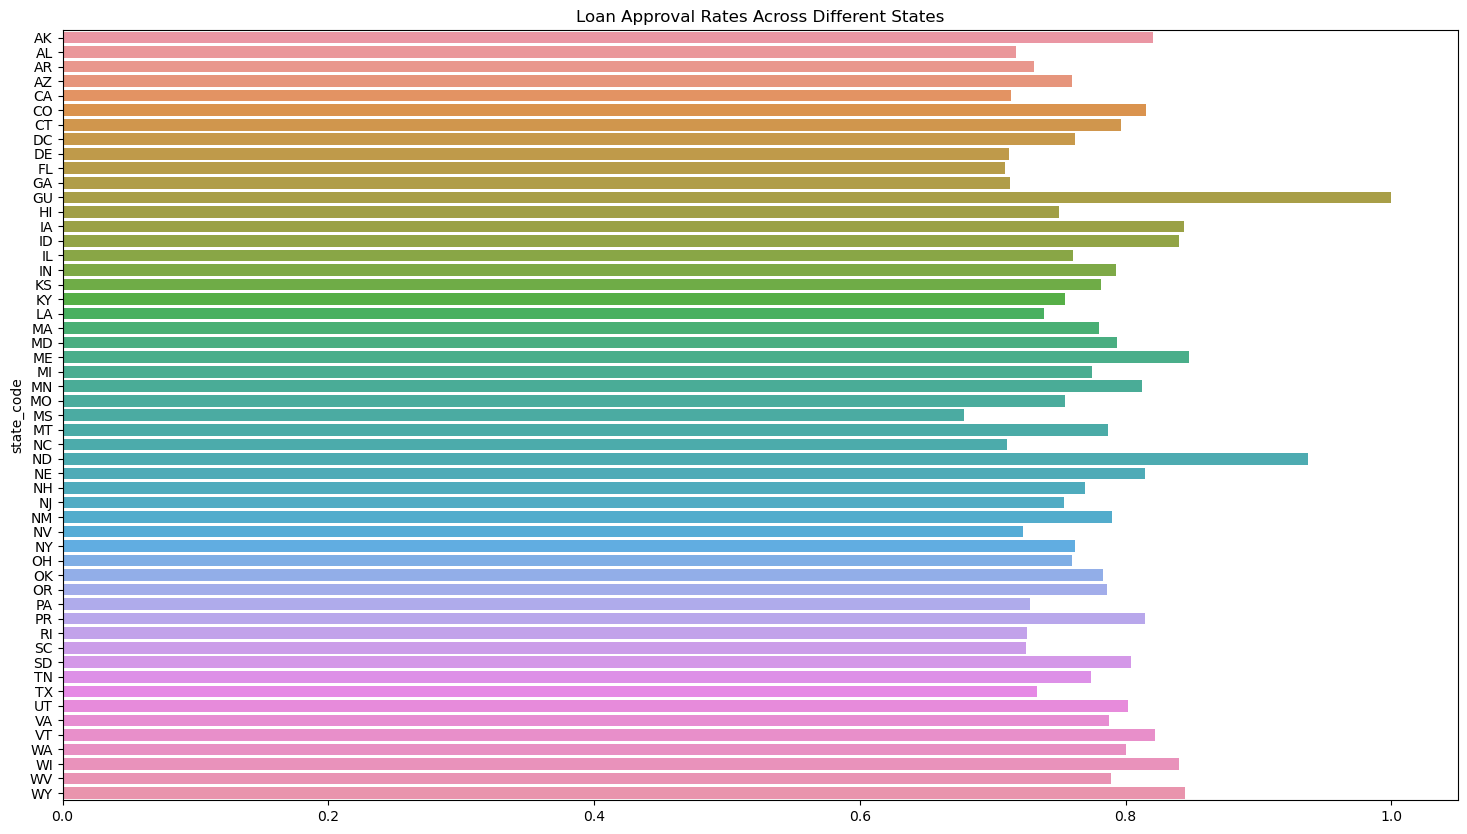

In [45]:
statecode_rates = sampled_data.groupby('state_code')['action_taken'].value_counts(normalize=True).loc[:,1]

plt.figure(figsize=(18,10))
sns.barplot(x=statecode_rates.values, y=statecode_rates.index, orient='h')

plt.title("Loan Approval Rates Across Different States")
plt.show()


> **`Feature: debt_to_income_ratio`**



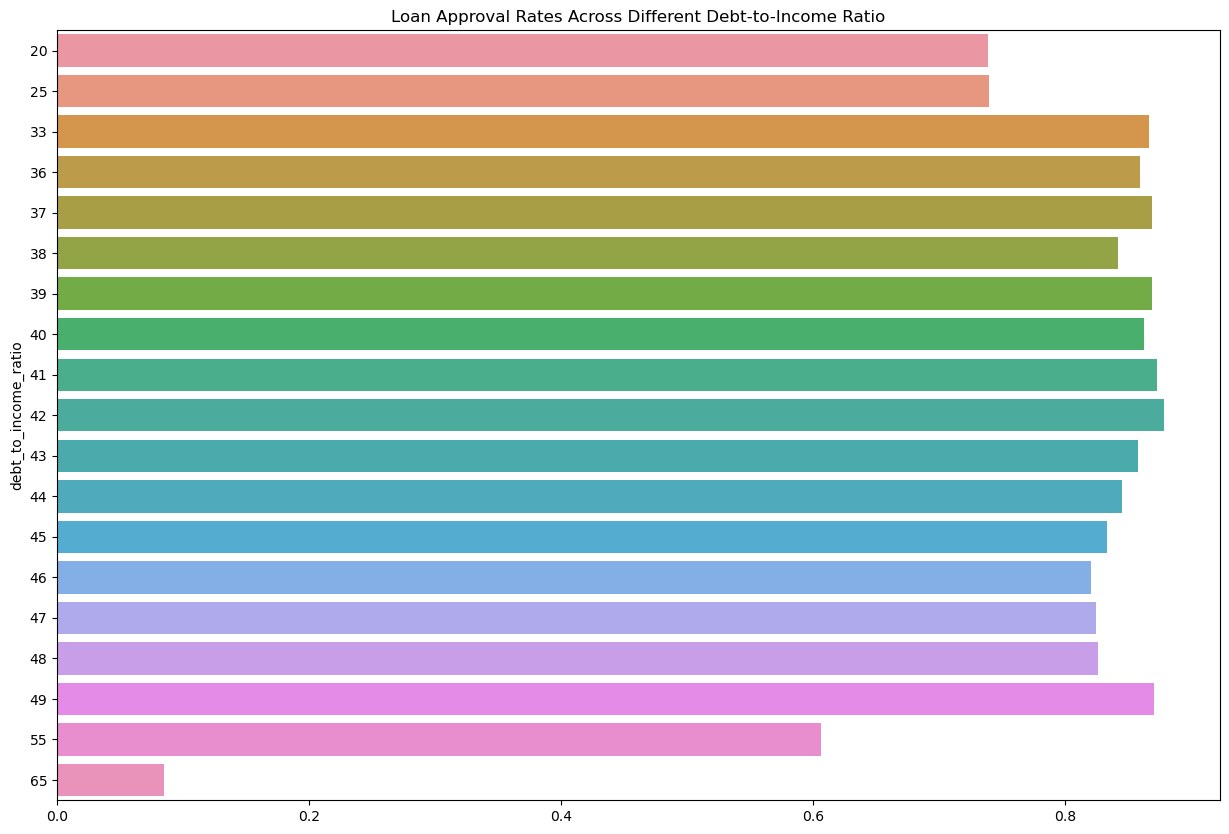

In [46]:
debt_to_income_rates = sampled_data.groupby('debt_to_income_ratio')['action_taken'].value_counts(normalize=True).loc[:,1]

plt.figure(figsize=(15,10))
sns.barplot(x=debt_to_income_rates.values, y=debt_to_income_rates.index, orient='h')

plt.title("Loan Approval Rates Across Different Debt-to-Income Ratio")
plt.show()

> **`Feature: loan_purpose`**




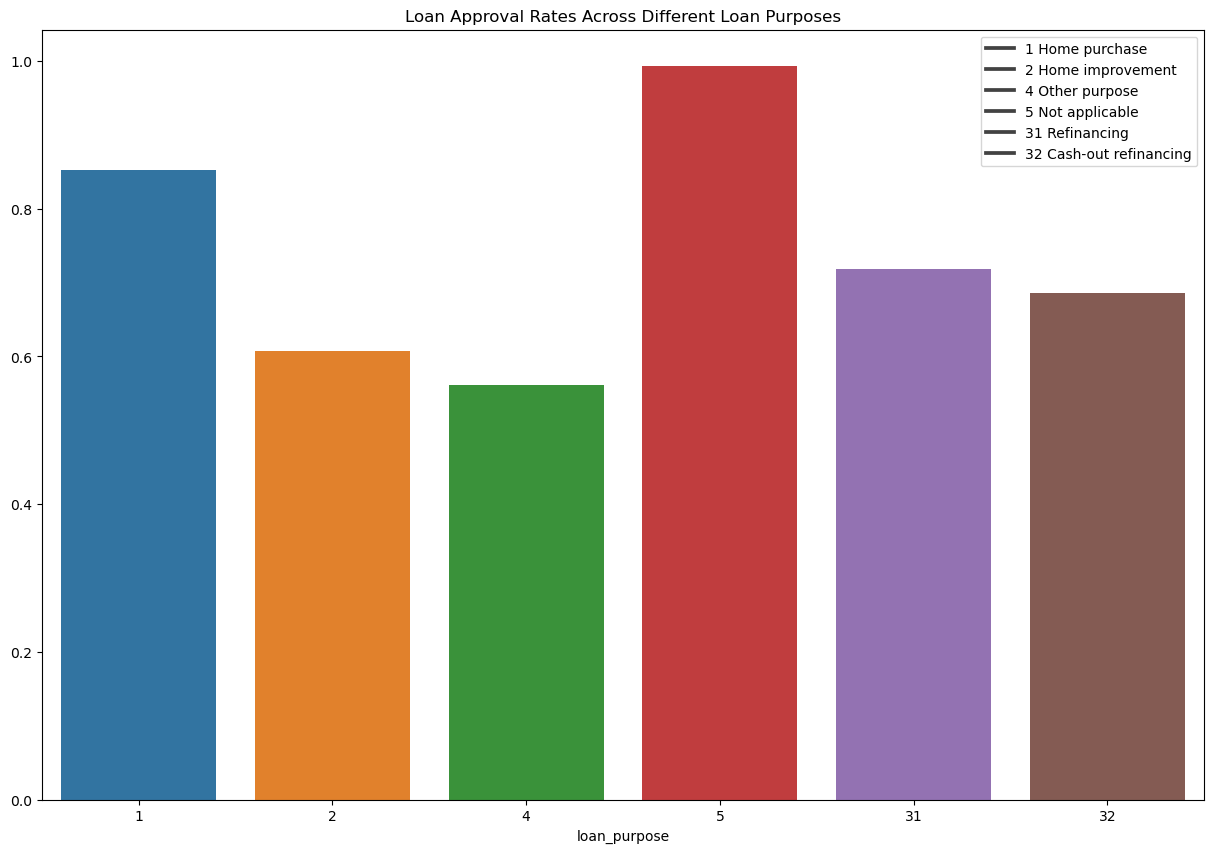

In [47]:
loanpurpose_rates = sampled_data.groupby('loan_purpose')['action_taken'].value_counts(normalize=True).loc[:,1]

plt.figure(figsize=(15,10))
sns.barplot(x=loanpurpose_rates.index, y=loanpurpose_rates.values)

labels = {
 1:  'Home purchase',
 2:  'Home improvement',
 31: 'Refinancing',
 32: 'Cash-out refinancing',
 4:  'Other purpose',
 5:  'Not applicable'
       }

# Create the legend
legend_labels = [f'{action} {labels[action]}' for action in loanpurpose_rates.index]
plt.legend(legend_labels, loc='upper right')
plt.title("Loan Approval Rates Across Different Loan Purposes")


# Show the plot
plt.show()


> **`Feature: hoepa status`**



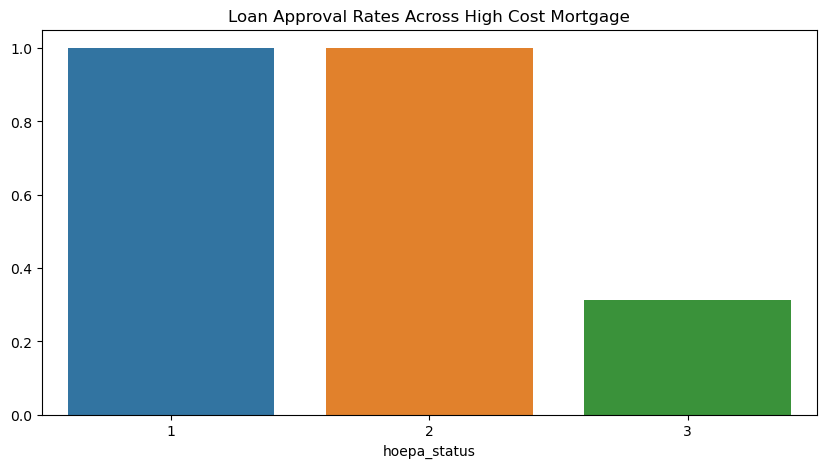

In [48]:
hoepa_rates = sampled_data.groupby('hoepa_status')['action_taken'].value_counts(normalize=True).loc[:,1]

plt.figure(figsize=(10,5))
sns.barplot(x=hoepa_rates.index, y=hoepa_rates.values)

plt.title("Loan Approval Rates Across High Cost Mortgage") #1-high cost #2 not hih cost #3- N/A
plt.show()

> **`Feature: Applicant Race`**

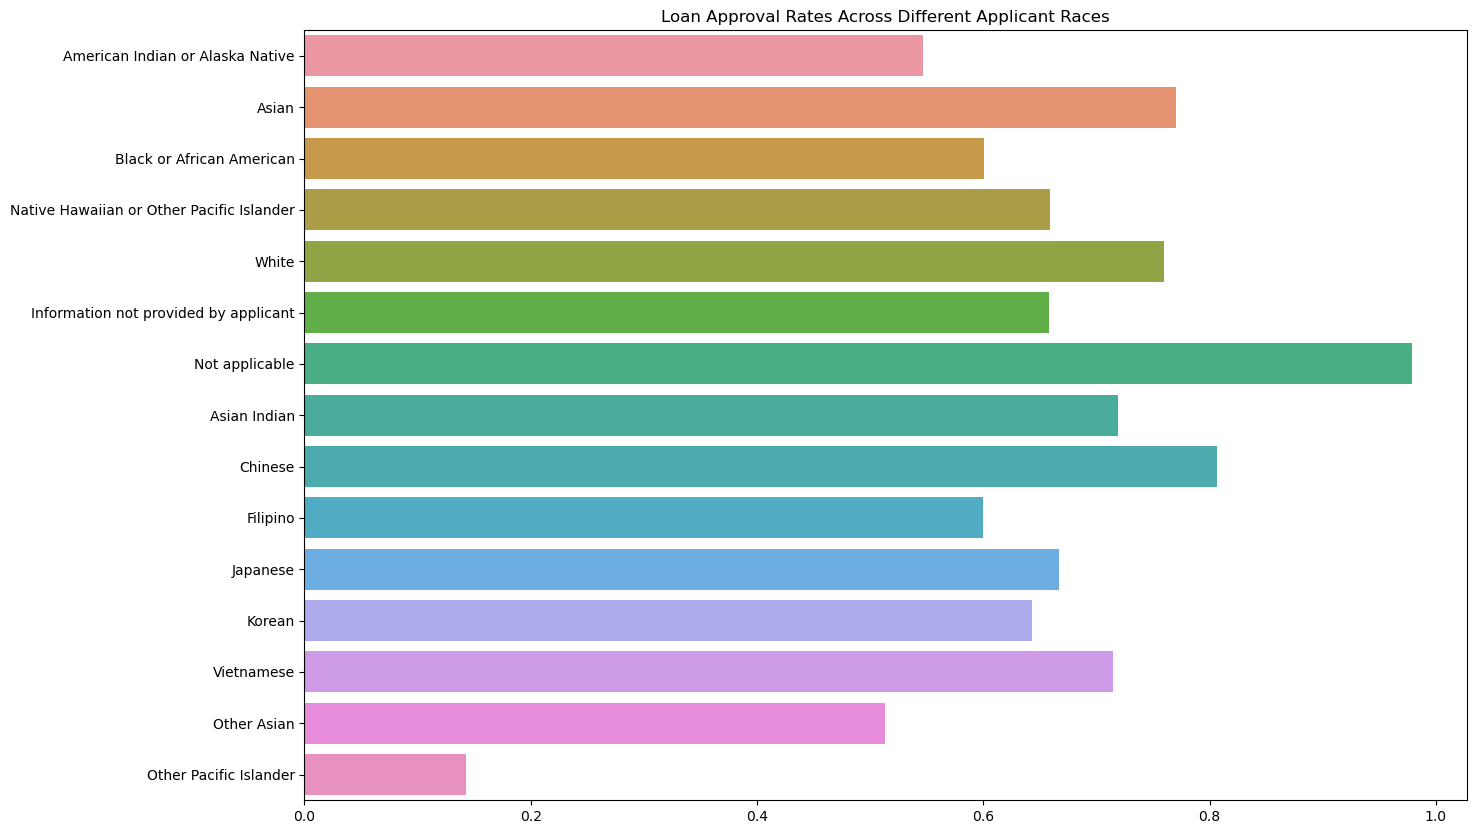

In [49]:

race_labels = {
    1: 'American Indian or Alaska Native',
    2: 'Asian',
    21: 'Asian Indian',
    22: 'Chinese',
    23: 'Filipino',
    24: 'Japanese',
    25: 'Korean',
    26: 'Vietnamese',
    27: 'Other Asian',
    3: 'Black or African American',
    4: 'Native Hawaiian or Other Pacific Islander',
    41: 'Native Hawaiian',
    42: 'Guamanian or Chamorro',
    43: 'Samoan',
    44: 'Other Pacific Islander',
    5: 'White',
    6: 'Information not provided by applicant',
    7: 'Not applicable'
}

# Group data and calculate loan approval rates by applicant race
race_rates = sampled_data.groupby('applicant_race_1')['action_taken'].value_counts(normalize=True).loc[:, 1]


plt.figure(figsize=(15, 10))
sns.barplot(x=race_rates.values, y=[race_labels[x] for x in race_rates.index], orient='h')



# Set the title
plt.title("Loan Approval Rates Across Different Applicant Races")

# Display the plot
plt.show()
